# `friedrich` results

In [1]:
%matplotlib inline
# Import dev version of friedrich:
import sys
sys.path.insert(0, '../')

import numpy as np
import matplotlib.pyplot as plt
from friedrich.analysis import Transit, Spot, Measurement, MCMCResults
from friedrich.lightcurve import hat11_params_morris_is_100
from glob import glob

archive_paths = sorted(glob('/local/tmp/friedrich/hat11_flip_lambda/chains???.hdf5'))
#archive_paths = sorted(glob('/local/tmp/friedrich/hat11_init/chains???.hdf5'))
print('load results')
transits = []
all_times = []
for archive_path in archive_paths:
    m = MCMCResults(archive_path, hat11_params_morris_is_100())
    all_times.extend(m.lc.times.jd)

#     # Convert samples into spot measurements
#     results = np.percentile(m.chains, [15.87, 50, 84.13], axis=0)

#     spots = []
#     for spot in np.split(results[:, 1:].T, (m.chains.shape[1]-1)/3):
#         ampltiude, t0, sigma = map(lambda x: Measurement(*(x[1], 
#                                                            x[2]-x[1], 
#                                                            x[1]-x[0])), 
#                                    spot)
#         spots.append(Spot(ampltiude, t0, sigma)) 
    spots = m.get_spots()
    transits.append(Transit(spots))

load results


In [2]:
from friedrich.orientation import times_to_occulted_lat_lon
from astroML.plotting import plot_tissot_ellipse

transit_params = hat11_params_morris_is_100()

all_lats = []
all_lons = []
all_amps = []
all_spot_times = []
all_BICs = []
for transit in transits:
    for spot in transit.spots: 
        latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                        transit_params)
        all_lats.append(latitude)
        all_lons.append(longitude)
        all_amps.append(spot.amplitude.value)
        all_spot_times.append(spot.t0.value)
        all_BICs.append(spot.delta_BIC)
all_lats = np.array(all_lats)
all_lons = np.array(all_lons)
all_amps = np.array(all_amps)
all_spot_times = np.array(all_spot_times)
all_BICs = np.array(all_BICs)

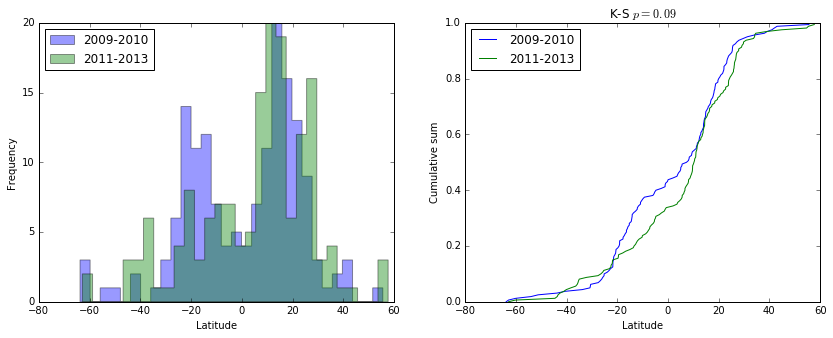

In [3]:
strong_lats = all_lats[all_BICs > 10]
strong_lats_times = all_spot_times[all_BICs > 10]
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
first_half_strong_lats = strong_lats[:int(0.5*len(strong_lats))]
second_half_strong_lats = strong_lats[-len(first_half_strong_lats):]

nbins = 30
ax[0].hist(np.degrees(first_half_strong_lats), nbins, histtype='stepfilled',
           facecolor='b', alpha=0.4, label='2009-2010')
ax[0].hist(np.degrees(second_half_strong_lats), nbins, histtype='stepfilled', 
           facecolor='g', alpha=0.4, label='2011-2013')

def cumdist(Z):
    N = len(Z)
    return np.sort(Z.ravel()), np.arange(N)/N

ax[1].plot(*cumdist(np.degrees(first_half_strong_lats)), label='2009-2010')
ax[1].plot(*cumdist(np.degrees(second_half_strong_lats)), label='2011-2013')

from scipy.stats import ks_2samp
ks = ks_2samp(first_half_strong_lats.ravel(), second_half_strong_lats.ravel())

ax[0].legend(loc='upper left')
ax[0].set(xlabel='Latitude', ylabel='Frequency')
ax[1].legend(loc='upper left')
ax[1].set(xlabel='Latitude', ylabel='Cumulative sum', 
          title="K-S $p={0:.2f}$".format(ks.pvalue))
plt.show()

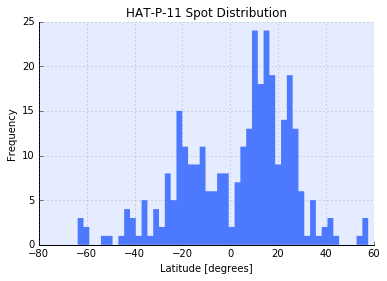

In [4]:
#import seaborn as sns
#sns.set(style="dark")

fig, ax = plt.subplots()
ax.grid(color='gray')
ax.hist(np.degrees(strong_lats), 50, histtype='stepfilled', 
        zorder=100, color='#4d79ff', edgecolor='none')
ax.set_xlabel('Latitude [degrees]')

ax.spines['right'].set_color('none')
ax.yaxis.set_ticks_position('left')

ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')

ax.set_ylabel('Frequency')
ax.set_axis_bgcolor('#e6ecff')
ax.set_title('HAT-P-11 Spot Distribution')
plt.savefig('plots/latitudes.pdf', bbox_inches='tight')
plt.show()

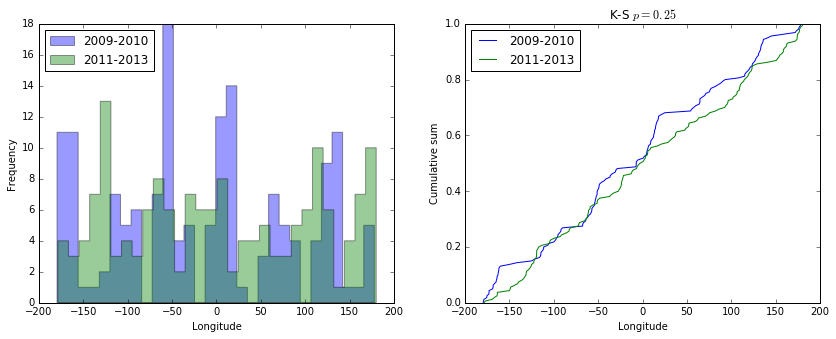

In [5]:
strong_lons = all_lons[all_BICs > 10]
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
first_half_strong_lons = strong_lons[:int(0.5*len(strong_lons))]
second_half_strong_lons = strong_lons[-len(first_half_strong_lons):]

nbins = 30
ax[0].hist(np.degrees(first_half_strong_lons), nbins, histtype='stepfilled',
           facecolor='b', alpha=0.4, label='2009-2010')
ax[0].hist(np.degrees(second_half_strong_lons), nbins, histtype='stepfilled', 
           facecolor='g', alpha=0.4, label='2011-2013')

def cumdist(Z):
    N = len(Z)
    return np.sort(Z.ravel()), np.arange(N)/N

ax[1].plot(*cumdist(np.degrees(first_half_strong_lons)), label='2009-2010')
ax[1].plot(*cumdist(np.degrees(second_half_strong_lons)), label='2011-2013')

from scipy.stats import ks_2samp
ks = ks_2samp(first_half_strong_lons.ravel(), second_half_strong_lons.ravel())

ax[0].legend(loc='upper left')
ax[0].set(xlabel='Longitude', ylabel='Frequency')
ax[1].legend(loc='upper left')
ax[1].set(xlabel='Longitude', ylabel='Cumulative sum', 
          title="K-S $p={0:.2f}$".format(ks.pvalue))
plt.show()

In [6]:
import friedrich
import imp
imp.reload(friedrich)
import friedrich

from friedrich.orientation import times_to_occulted_lat_lon

lats = np.zeros(len(all_times))#[]
lons = np.zeros(len(all_times))#[]
for i, t in enumerate(all_times):
    lat, lon = times_to_occulted_lat_lon(np.array([t]), transit_params)
    lats[i] = lat
    lons[i] = lon

../friedrich/orientation.py:383: RuntimeWarning: invalid value encountered in sqrt
  projected_z = np.sqrt(1 - x**2 - y**2)


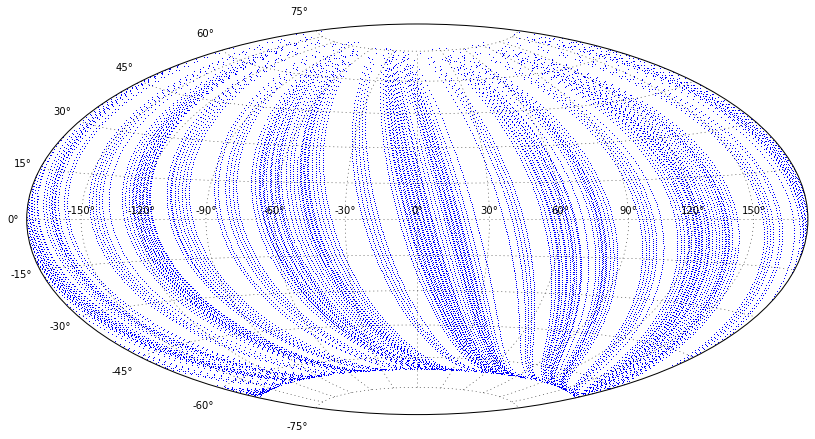

In [7]:
projection = 'Hammer'

# Plot the built-in projections
fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(111, projection=projection.lower())
ax.plot(lons, lats, ',')
ax.grid()

In [8]:
n_bins = 100
lon_grid = np.linspace(-np.pi, np.pi, n_bins)
lat_grid = np.linspace(-np.pi/2, np.pi/2, n_bins)

bins = np.zeros((n_bins, n_bins))
spots_in_visit_bin = np.zeros((n_bins, n_bins))
for i in range(n_bins-1):
    
    lon_bin_lower = lon_grid[i]
    lon_bin_upper = lon_grid[i+1]

    visits_in_lon_bin = ((lons < lon_bin_upper) & 
                         (lons > lon_bin_lower))
    spots_in_lon_bin = ((strong_lons < lon_bin_upper) & 
                        (strong_lons > lon_bin_lower))
    
    for j in range(n_bins-1):
        
        lat_bin_lower = lat_grid[j]
        lat_bin_upper = lat_grid[j+1]

        visits_in_lat_bin = ((lats < lat_bin_upper) & 
                      (lats > lat_bin_lower))
        
        bins[j, i] = np.count_nonzero(visits_in_lat_bin & 
                                      visits_in_lon_bin)

        spots_in_lat_bin = ((strong_lats < lat_bin_upper) & 
                            (strong_lats > lat_bin_lower))
        
        spots_in_visit_bin[j, i] = np.count_nonzero(spots_in_lon_bin &
                                              spots_in_lat_bin)
        
# plt.imshow(bins, interpolation='nearest', origin='lower')
# fig = plt.figure(figsize=(14, 14))
# ax = plt.subplot(111, projection=projection.lower())
# ax.plot(lon_grid, lat_grid, ',')
# ax.grid()

/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less
/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater
/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in less
/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in greater


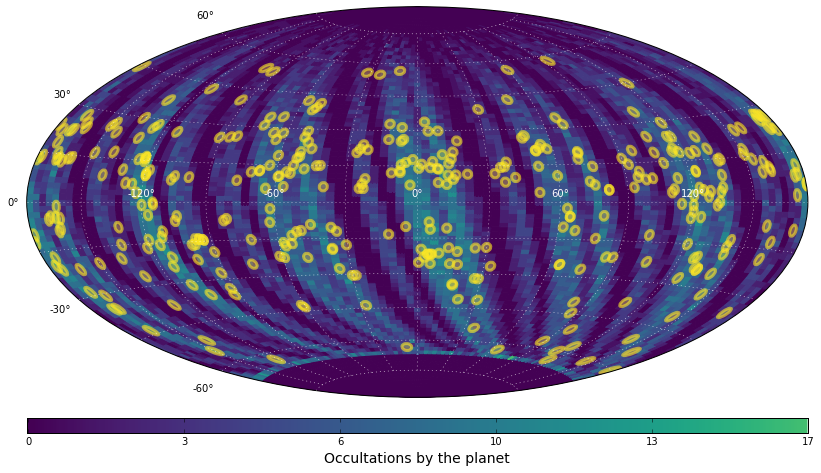

In [9]:
projection = 'Hammer'

cmap = plt.cm.viridis # plt.cm.copper
fraction_of_colorbar = 0.7
circle_color = plt.cm.viridis(1.0)
radius = 1.0*np.tan(transit_params.rp)

def color_scale(x):
    return fraction_of_colorbar*(x - bins.min()) / bins.max()
    #return (x - bins.min()) / 2 / bins.max()

# Plot the built-in projections
fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(211, projection=projection.lower())

for i in range(n_bins-1):
    lon_bin_lower = lon_grid[i]
    lon_bin_upper = lon_grid[i+1]
    for j in range(n_bins-1):
        lat_bin_lower = lat_grid[j]
        lat_bin_upper = lat_grid[j+1]
        
        # [lon min, lon max], [lat min, lat min], [lat max]
        ax.fill_between([lon_bin_lower, lon_bin_upper], 
                        [lat_bin_lower, lat_bin_lower], 
                        lat_bin_upper, 
                        color=cmap(color_scale(bins[j, i])))

def custom_grid(ax, color='gray'):
    # plot latitude/longitude grid
    ax.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3
                                                * np.linspace(-2, 2, 5)))
    ax.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6
                                                * np.linspace(-5, 5, 11)))
    ax.yaxis.set_major_locator(plt.FixedLocator(np.pi / 6
                                                * np.linspace(-2, 2, 5)))
    ax.yaxis.set_minor_locator(plt.FixedLocator(np.pi / 12
                                                * np.linspace(-5, 5, 11)))

    ax.grid(True, which='minor', color=color, ls=':')
    
    if color != 'gray':
        for l in ax.get_xticklabels():
            l.set_color(color)
        
def plot_colorbar(fig, ax):
    gradient = np.linspace(0, fraction_of_colorbar, 256)
    gradient = np.vstack(5*[gradient])

    ax.imshow(gradient, cmap=cmap, aspect=1.0, vmin=0, vmax=1) 
    ax.set_yticks([])
    nticks = 6
    axspace = np.linspace(0, 256, nticks)
    xticks = np.linspace(bins.min(), bins.max(), nticks).astype(int)
    ax.set_xticks(axspace)
    ax.set_xticklabels(xticks)

ax2 = plt.subplot(212)
plot_colorbar(fig, ax2)
fig.subplots_adjust(hspace=-0.6)

# plot spots
for transit in transits:
    for spot in transit.spots: 
        latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                        transit_params)

        p = plot_tissot_ellipse(longitude, latitude, radius, ax=ax, facecolor='none', 
                                edgecolor=circle_color, lw=3, alpha=0.6)
        
        p = plot_tissot_ellipse(longitude, latitude, radius, ax=ax, linewidth=0,
                                alpha=0.3, facecolor=circle_color)
        
custom_grid(ax, color='w')
ax2.set_xlabel('Occultations by the planet', fontsize=14)

In [10]:
fig.savefig('plots/map.pdf', bbox_inches='tight', dpi=1500)
#fig.savefig('plots/map.png', bbox_inches='tight', dpi=1500)

In [11]:
%%bash 
convert -channel RGBA -colorspace RGB -density 1500 plots/map.pdf -quality 100 plots/map_imagemagick.png

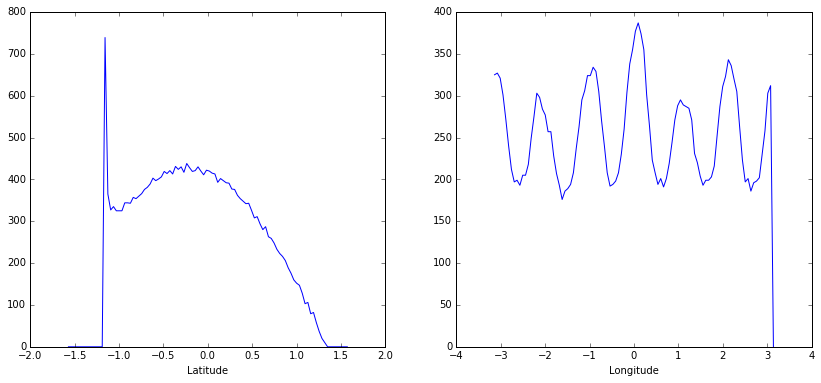

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(lat_grid, np.sum(bins, axis=1))
ax[0].set(xlabel='Latitude')
ax[1].plot(lon_grid, np.sum(bins, axis=0))
ax[1].set(xlabel='Longitude')

/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


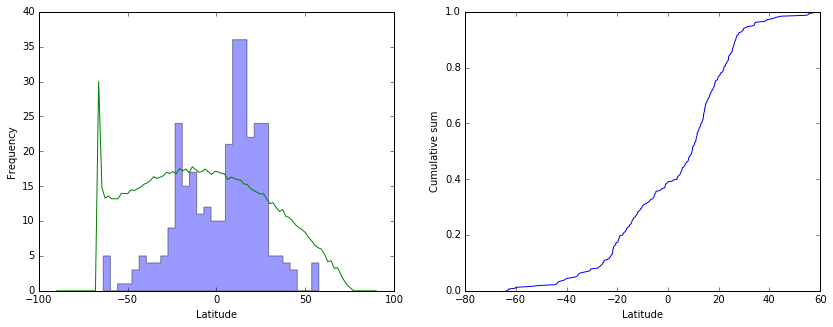

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
first_half_strong_lats = strong_lats[:int(0.5*len(strong_lats))]
second_half_strong_lats = strong_lats[-len(first_half_strong_lats):]

nbins = 30
ax[0].hist(np.degrees(strong_lats), nbins, histtype='stepfilled',
           facecolor='b', alpha=0.4)

def cumdist(Z):
    N = len(Z)
    return np.sort(Z.ravel()), np.arange(N)/N

ax[1].plot(*cumdist(np.degrees(strong_lats)))

sum_lats = np.sum(bins, axis=1)
ax[0].plot(np.degrees(lat_grid), sum_lats*30/sum_lats.max())
ax[0].legend(loc='upper left')
ax[0].set(xlabel='Latitude', ylabel='Frequency')
ax[1].legend(loc='upper left')
ax[1].set(xlabel='Latitude', ylabel='Cumulative sum'), 
         #title="K-S $p={0:.2f}$".format(ks.pvalue))
plt.show()

Latitude distribution with time: 

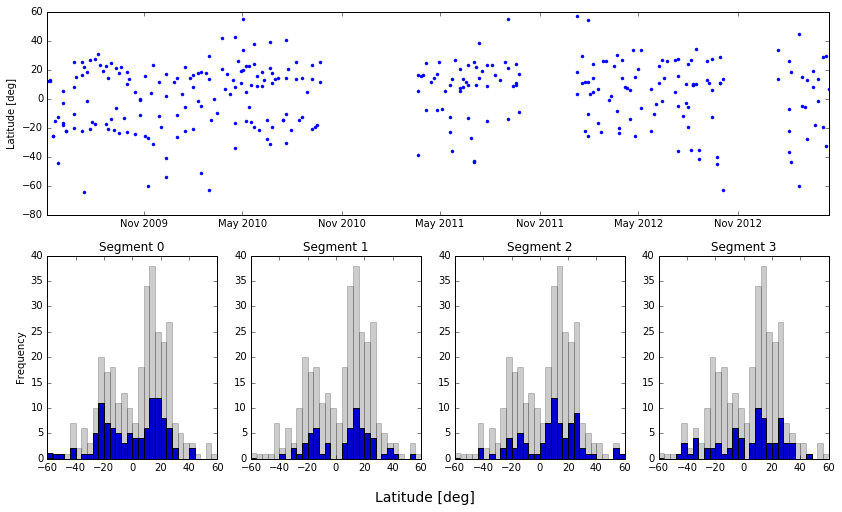

In [14]:

#all_amps
# plt.plot_date(Time(all_spot_times[all_BICs > 10], format='jd').plot_date, 
#               np.degrees(all_lats[all_BICs > 10]), '.')
from astropy.time import Time

n_panels = 4
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 4)
ax0 = plt.subplot(gs[0, :])
ax1 = [plt.subplot(gs[1, i]) for i in range(n_panels)]

#fig, ax = plt.subplots(1, n_panels, figsize=(14, 3))
first_spot = all_spot_times[all_BICs > 10].min()
last_spot = all_spot_times[all_BICs > 10].max()
first_to_last = last_spot - first_spot
fraction_gt_median = np.zeros(n_panels)

ax0.plot_date(Time(all_spot_times[all_BICs > 10], format='jd').plot_date, 
              np.degrees(all_lats[all_BICs > 10]), '.')

for i in range(n_panels):
    extent = [-60, 60]
    within_time_bin = ((all_spot_times[all_BICs > 10] - first_spot > 
                        i/n_panels*first_to_last) & 
                       (all_spot_times[all_BICs > 10] - first_spot < 
                        (i+1)/n_panels*first_to_last))
    lats_in_time_bin = np.degrees(all_lats[all_BICs > 10][within_time_bin])
    ax1[i].hist(lats_in_time_bin, 30, range=extent)

    ax1[i].hist(np.degrees(all_lats[all_BICs > 10]), 30,
                range=extent, alpha=0.2, color='k', zorder=10)

    ax1[i].set_xlim(extent)
    
    ax1[i].set(title='Segment {0}'.format(i))
    
    if i == 0:
        segment_zero_mean = np.median(lats_in_time_bin)
    fraction_gt_median[i] = np.count_nonzero(lats_in_time_bin > segment_zero_mean)/len(lats_in_time_bin)

ax1[0].set_ylabel('Frequency')
ax0.set_ylabel('Latitude [deg]')

fig.text(0.5, 0.05, 'Latitude [deg]', ha='center', fontsize=14)

#fig.subplots_adjust()

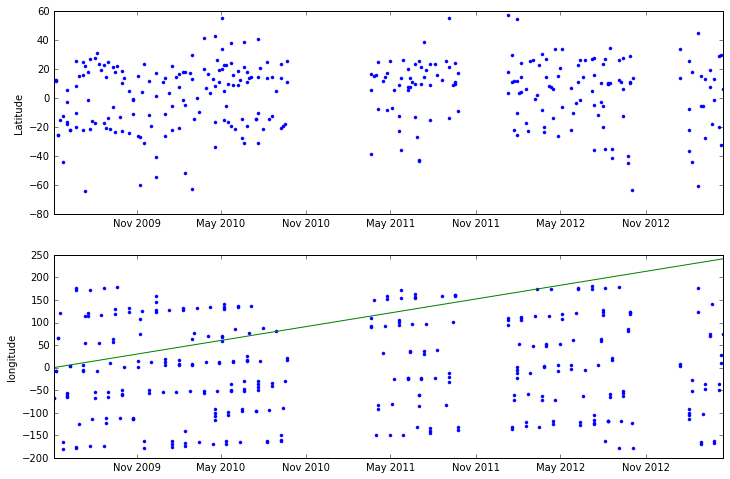

In [15]:

n_panels = 4
import matplotlib.gridspec as gridspec
# fig = plt.figure(figsize=(14, 8))
# gs = gridspec.GridSpec(2, 4)
# ax0 = plt.subplot(gs[0, :])
# ax1 = [plt.subplot(gs[1, i]) for i in range(n_panels)]

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

#fig, ax = plt.subplots(1, n_panels, figsize=(14, 3))
first_spot = all_spot_times[all_BICs > 10].min()
last_spot = all_spot_times[all_BICs > 10].max()
first_to_last = last_spot - first_spot
fraction_gt_median = np.zeros(n_panels)

ax[0].plot_date(Time(all_spot_times[all_BICs > 10], format='jd').plot_date, 
              np.degrees(all_lats[all_BICs > 10]), '.')

ax[1].plot_date(Time(all_spot_times[all_BICs > 10], format='jd').plot_date, 
              np.degrees(all_lons[all_BICs > 10]), '.')


x = Time(all_spot_times[all_BICs > 10], format='jd').plot_date
y = (transit_params.per/transit_params.per_rot)*(x - x[0])
ax[1].plot(x, y)


# for i in range(n_panels):
#     extent = [-60, 60]
#     within_time_bin = ((all_spot_times[all_BICs > 10] - first_spot > 
#                         i/n_panels*first_to_last) & 
#                        (all_spot_times[all_BICs > 10] - first_spot < 
#                         (i+1)/n_panels*first_to_last))
#     lats_in_time_bin = np.degrees(all_lats[all_BICs > 10][within_time_bin])
#     ax1[i].hist(lats_in_time_bin, 30, range=extent)

#     ax1[i].hist(np.degrees(all_lats[all_BICs > 10]), 30,
#                 range=extent, alpha=0.2, color='k', zorder=10)

#     ax1[i].set_xlim(extent)
    
#     ax1[i].set(title='Segment {0}'.format(i))
    
#     if i == 0:
#         segment_zero_mean = np.median(lats_in_time_bin)
#     fraction_gt_median[i] = np.count_nonzero(lats_in_time_bin > segment_zero_mean)/len(lats_in_time_bin)

# ax1[0].set_ylabel('Frequency')
# ax0.set_ylabel('Latitude [deg]')

ax[0].set_ylabel('Latitude')
ax[1].set_ylabel('longitude')
fig.savefig('plots/latlon.png', bbox_inches='tight', dpi=200)
# fig.text(0.5, 0.05, 'Latitude [deg]', ha='center', fontsize=14)

#fig.subplots_adjust()

(0, 1)

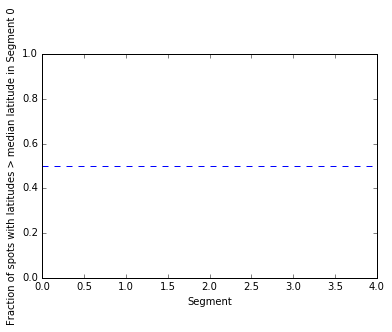

In [16]:
plt.figure()
plt.bar(range(n_panels), fraction_gt_median)
plt.xlabel('Segment')
plt.ylabel('Fraction of spots with latitudes > median latitude in Segment 0')
plt.axhline(0.5, ls='--')
plt.ylim([0, 1])